<a href="https://colab.research.google.com/github/kdidi99/ml_heidelberg/blob/main/naive-bayes-commented.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Exercise 3**

Team members:

*   Rudolf Braun
*   Jannik Schacht
*   Kieran Didi

#Data preparation

<font color='green'><b>
There is nothing to comment on this part, since it has just been copied from the last exercise.

In [ ]:
from sklearn.datasets import load_digits
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [ ]:
digits = load_digits() 
data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

Data filtering (indeed we have 361 instances with a dimension of 8x8=64 each)



In [ ]:
X_all = data
y_all = target

X_filter = X_all[np.logical_or(3 == y_all, 9 == y_all)]
y_filter = y_all[np.logical_or(3 == y_all, 9 == y_all)]
X_filter.shape

(363, 64)

Visualize a few numbers to make sure we have the correct images

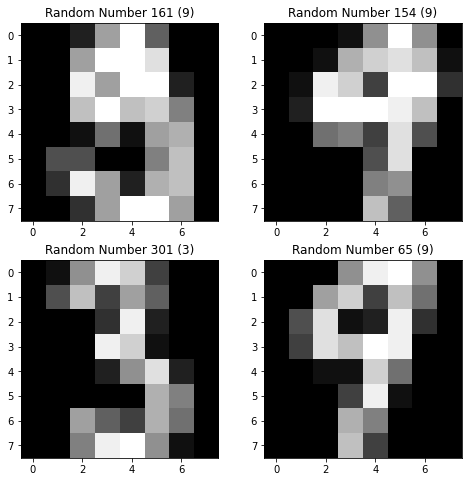

In [ ]:
fig, axs = plt.subplots(2, 2)
sel = np.random.randint(low=0, high=361, size=4)
for r, x, y in zip(sel, [0, 0, 1, 1], [0, 1, 0, 1]):
    img = X_filter[r, :].reshape((8,8))
    assert 2 == len(img.shape)
    axs[x, y].imshow(img, interpolation="nearest", cmap="gray")
    axs[x, y].set_title(f"Random Number {r} ({y_filter[r]})")
fig.set_size_inches(8, 8)

#Dimension Reduction

<font color='green'><b>
There is not much to comment on this part, since it has just been copied from the last exercise. 
<br>
Dimension reduction is individual and can differ from the sample solution.
<br>
Code has been slightly modified to work with digits 3 and 9 instead of 1 and 7.

In [ ]:
#separate 3's and 9's
X_three = X_filter[3 == y_filter]
X_nine = X_filter[9 == y_filter]

#calculate the means of each pixel in the respective classes and take the difference 
mean_diff = X_three.mean(axis=0)-X_nine.mean(axis=0)

#look for the top 5 pixels most bright for 1's and 7's respectively
idx_three = (mean_diff).argsort()[:5]
idx_nine = (-mean_diff).argsort()[:5]

print(idx_three)
print(mean_diff[idx_three])
print(idx_nine)
print(mean_diff[idx_nine])

[26 18 29 21 30]
[-8.95765027 -8.79508197 -8.45455373 -4.78870674 -3.75692168]
[36 20 58  4  2]
[6.95473588 3.71065574 3.58916211 2.96848816 2.70464481]


In [ ]:
def reduce_dim(x):
    #define indices to be selected
    idx_3 = np.array([26, 18])
    idx_9 = np.array([36, 20])
    #select entries via indices and calculate new features from them
    x_3 = np.sum(x.take(idx_3, axis=1), axis=1)
    x_9 = np.sum(x.take(idx_9, axis=1), axis=1)
    #reduced_x = x.take(idx, axis=1)
    #combine the two features into one array
    reduced_x = np.column_stack((x_3, x_9))
    return reduced_x


In [ ]:
#make sure that the dimensions of the reduced data are correct 
reduced_x = reduce_dim(X_filter)
reduced_x.shape

(363, 2)

Split into training and test set (for both reduced and not reduced features)

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_filter, y_filter,
   test_size = 0.4, random_state = 0)

X_train_r, X_test_r, y_train_r, y_test_r = model_selection.train_test_split(reduce_dim(X_filter), y_filter,
   test_size = 0.4, random_state = 0)

### Scatterplot

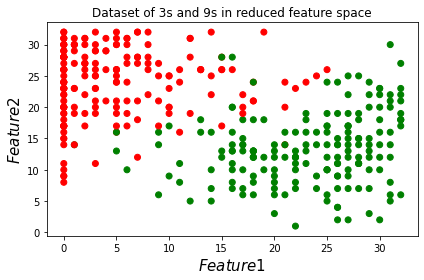

In [ ]:
#plt.style.use('_mpl-gallery')
fig, ax = plt.subplots()
color= ['red' if y == 3 else 'green' for y in y_filter]
ax.scatter(reduced_x[:,0], reduced_x[:,1], c=color)

ax.set_xlabel(r'$Feature 1$', fontsize=15)
ax.set_ylabel(r'$Feature 2$', fontsize=15)
ax.set_title('Dataset of 3s and 9s in reduced feature space')

fig.tight_layout()
plt.show()

The two classes don't overlap too much, but are present as two separate clusters as visualised in the plot above. From this we can conclude that the reduced features are informative enough to continue.

# 2. Naive Bayes classifier

Implement the training function:

(Due to lack of time, the automatic selection of bincount is not fully implemented yet. Therefore we used bincount = 4 for the reduced feature space instead).

In [ ]:
# returns histograms, binning and ulabels (= array containing all possible labels)
def fit_naive_bayes(features, labels, bincount):
    # check for valid parameters
    assert (np.size(features, axis=0) > 0 and np.size(labels, axis=0) == np.size(features, axis=0))

    # this part is not fully implemented yet
    if bincount==0:
        #determine bin width automatically with Freedman-Diaconis rule
        #needs to be added: sort array and then determine IQR for each feature
        iqr_val = np.quantile(features, q=[.25, .75])
        iqr = np.diff(iqr_val)[0]
        print(iqr_val)
        print(features)
        print(iqr)

    # calculate number of classes
    ulabels = np.unique(labels)
    c = ulabels.size
    
    # calculate feature dimensions
    d = np.size(features, axis=1)

    # initialize output arrays
    histograms = np.zeros((c,d,bincount))
    binning = np.zeros((c,d,2))

    # initialize temporary arrays
    histogram_counter = np.zeros((c,d,bincount))

    # process every possible class one by one
    for i in range(c):
        # only consider data instances belonging to the present class
        c_features = features[labels == ulabels[i]]
        c_size = np.size(c_features, axis=0)

        # calculate the minimum and maximum value for each of the features
        min = c_features.min(axis=0)
        max = c_features.max(axis=0)

        # write the minimum of each feature as the 'lower bound' to binning
        binning[i, :, 0] = min

        # calculate the binwidth h for each feature and write it to binning
        h = (max-min)/bincount
        h[h == 0] = 1               # prevent division by zero fault
        binning[i, :, 1] = h

        # for each instance belonging to the present class
        for x in range(c_size):
            # calculate the bin this instance belongs in
            m = np.floor((c_features[x] - min) / h).astype(int)
            m[m >= bincount] = bincount - 1

            # for each feature of the present instance:
            # increase the counter of the bin it belongs in
            histogram_counter[i, [*range(d)], m] = histogram_counter[i, [*range(d)], m] + 1

        # calculate the histograms
        histograms[i] = histogram_counter[i] / c_size

    return histograms, binning, ulabels

Implement the prediction function:

In [ ]:
def predict_naive_bayes(test_features, histograms, binning, ulabels):
    # number of classes
    c = np.size(ulabels, axis=0)

    # number of bins
    bincount = np.size(histograms, axis=2)

    # feature dimensions
    d = np.size(histograms, axis=1) 

    # initialize output array
    predicted_labels = []

    # iterate over all given instances and predict label for each
    for x in test_features:
        # initialize array for storing sums of logarithms
        sums = np.zeros(c)

        # calculate sum of logarithm for each possible class
        for i in range(c):
        
            # calculate bins for all features of the present instance
            m = np.floor((x - binning[i, :, 0]) / binning[i, :, 1]).astype(int)
            m[m >= bincount] = bincount - 1
            m[m < 0] = 0

            # calculate sum of logarithms of the 1-dimensional histograms for all features
            temp = histograms[i, [*range(d)], m]
            temp[temp == 0] = 1
            sum_of_log = np.sum(np.log(temp))
            sums[i] = sum_of_log
            
        # choose the label that belongs to the highest sum
        y_head = ulabels[np.argmax(sums)]
        predicted_labels.append(y_head)

    return np.array(predicted_labels)

Use the implemented functions:

In [ ]:
# reduced feature space and bincount = 4
histograms, binning, ulabels = fit_naive_bayes(X_train_r, y_train_r, 4)
predicted_labels_r = predict_naive_bayes(X_test_r, histograms, binning, ulabels)

# full feature space and bincount = 8
histograms, binning, ulabels = fit_naive_bayes(X_train, y_train, 8)
predicted_labels = predict_naive_bayes(X_test, histograms, binning, ulabels)

Calculate confusion matrix using sklearn:

In [ ]:
# Confusion matrix for reduced feature space and bincount = 4
confmat_r = confusion_matrix(y_test_r, predicted_labels_r, normalize='true')
confmat_r = confmat_r * 100
print("Confusion matrix for reduced feature space (bincount = 4):\n")
print(f"True negatives: {confmat_r[0,0]} %\nFalse negatives: {confmat_r[1,0]} %\nTrue positives: {confmat_r[1,1]} %\nFalse positives: {confmat_r[0,1]} %\n")

# Confusion matrix for full feature space and bincount = 8
confmat = confusion_matrix(y_test, predicted_labels, normalize='true')
confmat_r = confmat_r * 100
print("Confusion matrix for full feature space (bincount = 8):\n")
print(f"True negatives: {confmat[0,0]} %\nFalse negatives: {confmat[1,0]} %\nTrue positives: {confmat[1,1]} %\nFalse positives: {confmat[0,1]} %")

Confusion matrix for reduced feature space (bincount = 4):

True negatives: 90.27777777777779 %
False negatives: 2.7027027027027026 %
True positives: 97.2972972972973 %
False positives: 9.722222222222223 %

Confusion matrix for full feature space (bincount = 8):

True negatives: 0.875 %
False negatives: 0.013513513513513514 %
True positives: 0.9864864864864865 %
False positives: 0.125 %


Visualization could not be implemented due to lack of time :(

<font color='green'><b>
In the sample solution the scatter plots show very nicely the decision boundaries. Unfortunately, we did not have enough time to implement some visualization. The below code is not yet working.

In [ ]:
#create dataset for pixel image
f1 = np.linspace(1, 40, num=40)
f2 = np.linspace(1, 40, num=40)
xx, yy = np.meshgrid(f1,f2)
xx = xx.reshape(1,1600)
yy = yy.reshape(1,1600)
X_plot = np.dstack((xx,yy))
y_plot = predicted_labels
#y_plot = y_plot[:,0]
y_plot = y_plot.reshape(40,40)

#plot the pixel image dataset as decision boundary
fig, ax = plt.subplots()
color= ['red' if y == 1 else 'green' for y in y_test]
ax.imshow(y_plot, alpha = 0.5)

#add the test set data points
ax.scatter(X_test[:,0], X_test[:,1], c=color, marker = "+")

ax.set_xlabel(r'$Feature 1$', fontsize=15)
ax.set_ylabel(r'$Feature 2$', fontsize=15)
ax.set_title('Dataset of 1s and 7s in reduced feature space')

fig.tight_layout()
plt.show()